<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/08_Supervised_Sensitivity_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, Download, & Variable Statements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import & download statements
# General Statements
#!git clone https://github.com/d-atallah/implicit_gender_bias.git
#! pip install joblib
#! pip install shap
import pandas as pd
import string
import re
import joblib
#from implicit_gender_bias import config as cf
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import nltk
import sklearn
import spacy
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection & Model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD,PCA, NMF
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, log_loss, make_scorer, average_precision_score

# Model options
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
nlp = spacy.load("en_core_web_sm")

## Read Inputs

In [ ]:
# Variables
folder_path = '/home/gibsonce/datallah-jaymefis-gibsonce/'

# Load DataFrames from pkl files

X_train = pd.read_pickle(folder_path + 'X_train_preprocessed.pkl')
X_test = pd.read_pickle(folder_path + 'X_test_preprocessed.pkl')
y_train = pd.read_pickle(folder_path + 'y_train.pkl')
y_test = pd.read_pickle(folder_path + 'y_test.pkl')

## Define Functions


In [ ]:
def tokenize_and_categorize_batch(texts):
    docs = list(nlp.pipe(texts))
    word_features = [' '.join([token.text for token in doc]) for doc in docs]
    pos_tags = [' '.join([token.pos_ for token in doc]) for doc in docs]

    return word_features, pos_tags

In [ ]:
def model_eval(pipeline, X_test, y_test):
    """
    Evaluates a specified model using accuracy, precision, recall, F-1 score, AUC-ROC & PR, log-Loss, and a confusion matrix.

    Parameters:
    - pipeline (object): Fitted pipeline.
    - X_test (list or array): Test set features.
    - y_test (list or array): True labels.

    Returns:
    - metrics_df (pd.DataFrame): DataFrame containing the metrics and scores.
    - confusion_df (pd.DataFrame): DataFrame containing a confusion matrix.
    """

    start_time = time.time()

    # Cross-validation
    scoring = {
        'f1': make_scorer(f1_score),
        'pr_auc': make_scorer(average_precision_score),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(pipeline, X_test, y_test, cv=cv, scoring=scoring)

    # Create DataFrame to store cross-validation results
    cv_metrics_df = pd.DataFrame({
    'Metric': ['F1-Score','AUC-PR'],
    'CV_Mean': [np.mean(cv_results['test_f1']),
                np.mean(cv_results['test_pr_auc']),
                ],
    'CV_Std Dev': [np.std(cv_results['test_f1']),
                   np.std(cv_results['test_pr_auc']),
                  ]
    })


    return cv_metrics_df

## XGBoost

### Remove nulls from preprocessing

In [ ]:
non_nan_indices_train = ~X_train.isnull()
non_nan_indices_test = ~X_test.isnull()

# Filter y_train and y_test using the non-NaN indices
y_train = y_train[non_nan_indices_train]
y_test = y_test[non_nan_indices_test]

# Filter X_train and X_test to remove NaN records
X_train = X_train[non_nan_indices_train]
X_test = X_test[non_nan_indices_test]

### Batch POS Tag

In [ ]:
start_time = time.time()

train_batch_size = 10000
test_batch_size = 10000

# Initialize empty pandas Series for training data
X_train_ = pd.Series(dtype='object')
X_train_pos = pd.Series(dtype='object')
# Initialize empty pandas Series for testing data
X_test_ = pd.Series(dtype='object')
X_test_pos = pd.Series(dtype='object')

# Iterator for training data
train_iterator = (X_train.iloc[i:i+train_batch_size] for i in range(0, len(X_train), train_batch_size))

# Concatenate each batch of results for training data
print('Train batch start')
i=0
for train_batch in train_iterator:
    print(i)
    X_train_word_features, X_train_pos_tags = tokenize_and_categorize_batch(train_batch)

    # Concatenate to the existing Series
    X_train_ = pd.concat([X_train_, pd.Series(X_train_word_features)])
    X_train_pos = pd.concat([X_train_pos, pd.Series(X_train_pos_tags)])
    i+=1

print('Train batch end')
# Iterator for testing data
test_iterator = (X_test.iloc[i:i+test_batch_size] for i in range(0, len(X_test), test_batch_size))

print('Test batch start')
# Concatenate each batch of results for testing data
i=0
for test_batch in test_iterator:
    print(i)
    X_test_word_features, X_test_pos_tags = tokenize_and_categorize_batch(test_batch)

    # Concatenate to the existing Series
    X_test_ = pd.concat([X_test_, pd.Series(X_test_word_features)])
    X_test_pos = pd.concat([X_test_pos, pd.Series(X_test_pos_tags)])
    i+=1

print('Test batch end')
# Reset the index of training data
X_train_.reset_index(drop=True, inplace=True)
X_train_pos.reset_index(drop=True, inplace=True)
# Reset the index of testing data
X_test_.reset_index(drop=True, inplace=True)
X_test_pos.reset_index(drop=True, inplace=True)

X_train = X_train_
X_test = X_test_
X_train_pos_tags = X_train_pos
X_test_pos_tags = X_test_pos

# Vectorize the word features
word_features_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train_word_features_ = word_features_vectorizer.fit_transform(X_train)
X_test_word_features_ = word_features_vectorizer.transform(X_test)

# Vectorize the parts of speech tags
pos_tags_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train_pos_tags_ = pos_tags_vectorizer.fit_transform(X_train_pos)
X_test_pos_tags_ = pos_tags_vectorizer.transform(X_test_pos)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Vectorization completed. Time elapsed: {elapsed_time/60:.2f} minutes.")

# Combine the vectorized word features and parts of speech tags
X_train_combined = scipy.sparse.hstack([X_train_word_features_, X_train_pos_tags_])
X_test_combined = scipy.sparse.hstack([X_test_word_features_, X_test_pos_tags_])

Train batch start
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
Train batch end
Test batch start
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Test batch end
Vectorization completed. Time elapsed: 14.16 minutes.


### Sensitivity Testing

In [ ]:
# Define hyperparameter values to test
subsample_values = [0.7, 0.8, 0.9]
n_estimators_values = [100, 150, 200]
max_depth_values = [7, 9, 11]
learning_rate_values = [0.01, 0.05, 0.1]
colsample_bytree_values = [0.4, 0.5, 0.6]

# Original params
params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
}

In [ ]:
sensitivity_df = pd.DataFrame(columns=['id','param','value', 'cv_mean', 'cv_std'])
data_to_concat = []

In [ ]:
for test in subsample_values:
    params = {
    'xgbclassifier': {'subsample': test, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
    }

    id = f'subsample: {test}'
    print(id)
    param = 'subsample'
    val = str(test)

    #metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
    # Fit model
    model = XGBClassifier(random_state=42, **params.get('xgbclassifier', {}))
    model.fit(X_train_combined, y_train)

    # Evaluate model
    metrics_df = model_eval(model, X_test_combined, y_test)
    #metrics_df['params'] = params

    data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))



subsample: 0.7
subsample: 0.8
subsample: 0.9


In [ ]:
for test in n_estimators_values:
    params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': test, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
    }

    id = f'n_estimators: {test}'
    print(id)
    param = 'n_estimators'
    val = str(test)

    #metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
    # Fit model
    model = XGBClassifier(random_state=42, **params.get('xgbclassifier', {}))
    model.fit(X_train_combined, y_train)

    # Evaluate model
    metrics_df = model_eval(model, X_test_combined, y_test)

    data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))



n_estimators: 100
n_estimators: 150
n_estimators: 200


In [ ]:
for test in max_depth_values:
    params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': test, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
    }

    id = f'max_depth: {test}'
    print(id)
    param = 'max_depth'
    val = str(test)

    #metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
    # Fit model
    model = XGBClassifier(random_state=42, **params.get('xgbclassifier', {}))
    model.fit(X_train_combined, y_train)

    # Evaluate model
    metrics_df = model_eval(model, X_test_combined, y_test)

    data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))



max_depth: 7
max_depth: 9
max_depth: 11


In [ ]:
for test in learning_rate_values:
    params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': test, 'colsample_bytree': 0.5},
    }

    id = f'learning_rate: {test}'
    print(id)
    param = 'learning_rate'
    val = str(test)

    #metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
    # Fit model
    model = XGBClassifier(random_state=42, **params.get('xgbclassifier', {}))
    model.fit(X_train_combined, y_train)

    # Evaluate model
    metrics_df = model_eval(model, X_test_combined, y_test)

    data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))

learning_rate: 0.01
learning_rate: 0.05
learning_rate: 0.1


In [ ]:
for test in colsample_bytree_values:
    params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': test},
    }

    id = f'colsample_bytree: {test}'
    print(id)
    param = 'colsample_bytree'
    val = str(test)

    #metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
    # Fit model
    model = XGBClassifier(random_state=42, **params.get('xgbclassifier', {}))
    model.fit(X_train_combined, y_train)

    # Evaluate model
    metrics_df = model_eval(model, X_test_combined, y_test)

    data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))

colsample_bytree: 0.4
colsample_bytree: 0.5
colsample_bytree: 0.6


In [ ]:
filtered_sensitivity_df = sensitivity_df[sensitivity_df['metric'] == 'F1-Score']
filtered_sensitivity_df

,id,param,value,metric,cv_mean,cv_std
0,max_depth: 7,max_depth,7.00,F1-Score,0.793478,0.000688
2,max_depth: 9,max_depth,9.00,F1-Score,0.794438,0.000451
4,max_depth: 11,max_depth,11.00,F1-Score,0.795450,0.000497
6,learning_rate: 0.01,learning_rate,0.01,F1-Score,0.788289,0.000523
8,learning_rate: 0.05,learning_rate,0.05,F1-Score,0.794438,0.000451
10,learning_rate: 0.1,learning_rate,0.10,F1-Score,0.796168,0.000765
12,colsample_bytree: 0.4,colsample_bytree,0.40,F1-Score,0.794569,0.000719
14,colsample_bytree: 0.5,colsample_bytree,0.50,F1-Score,0.794438,0.000451
16,colsample_bytree: 0.6,colsample_bytree,0.60,F1-Score,0.794643,0.000756
18,subsample: 0.7,subsample,0.70,F1-Score,0.794535,0.000498


In [ ]:
sensitivity_df = pd.concat(data_to_concat, ignore_index=True)
sensitivity_df.to_csv(f'{folder_path}sensitivity_results_fin.csv', index=False)

In [3]:
sensitivity_df = pd.read_csv('/content/drive/MyDrive/RtGender/sensitivity_results_fin.csv')
sensitivity_df

,id,param,value,metric,cv_mean,cv_std
0,max_depth: 7,max_depth,7.00,F1-Score,0.793478,0.000688
1,max_depth: 7,max_depth,7.00,AUC-PR,0.672762,0.000955
2,max_depth: 9,max_depth,9.00,F1-Score,0.794438,0.000451
3,max_depth: 9,max_depth,9.00,AUC-PR,0.675400,0.000793
4,max_depth: 11,max_depth,11.00,F1-Score,0.795450,0.000497
5,max_depth: 11,max_depth,11.00,AUC-PR,0.677962,0.000739
6,learning_rate: 0.01,learning_rate,0.01,F1-Score,0.788289,0.000523
7,learning_rate: 0.01,learning_rate,0.01,AUC-PR,0.658320,0.000560
8,learning_rate: 0.05,learning_rate,0.05,F1-Score,0.794438,0.000451
9,learning_rate: 0.05,learning_rate,0.05,AUC-PR,0.675400,0.000793


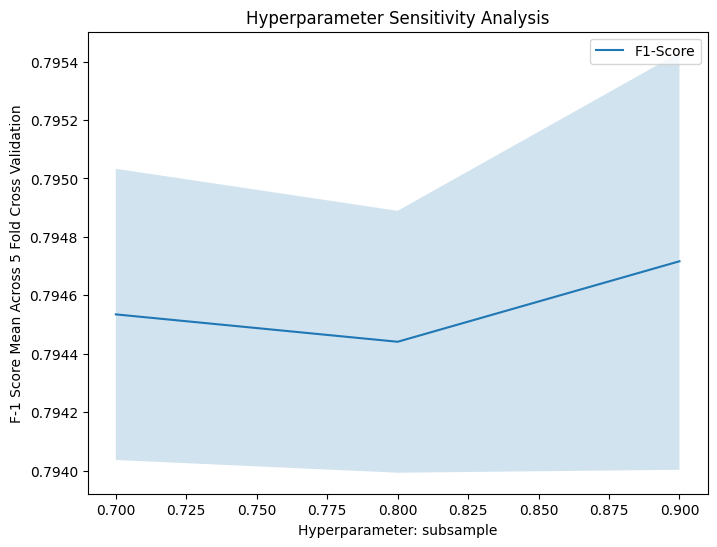

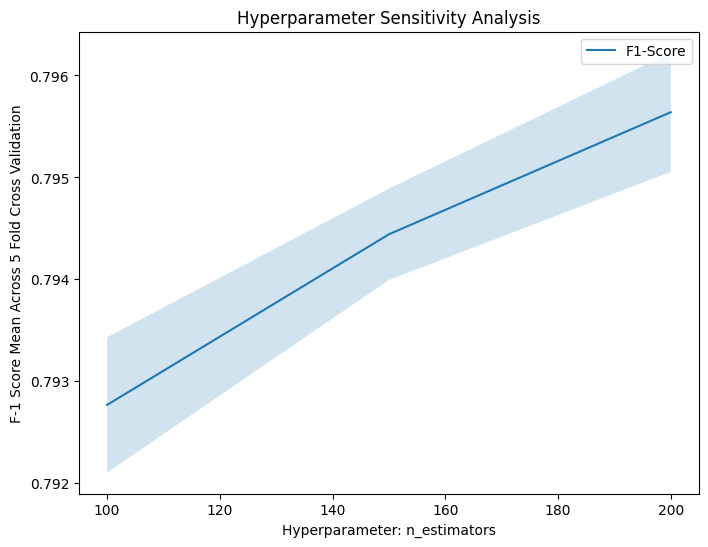

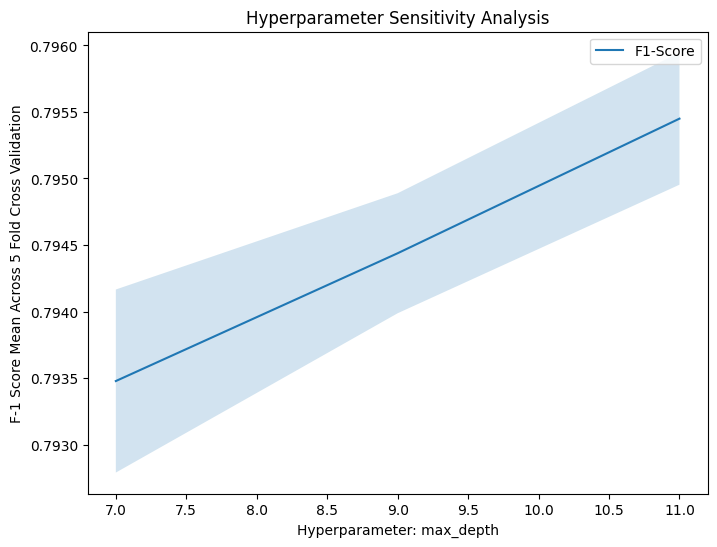

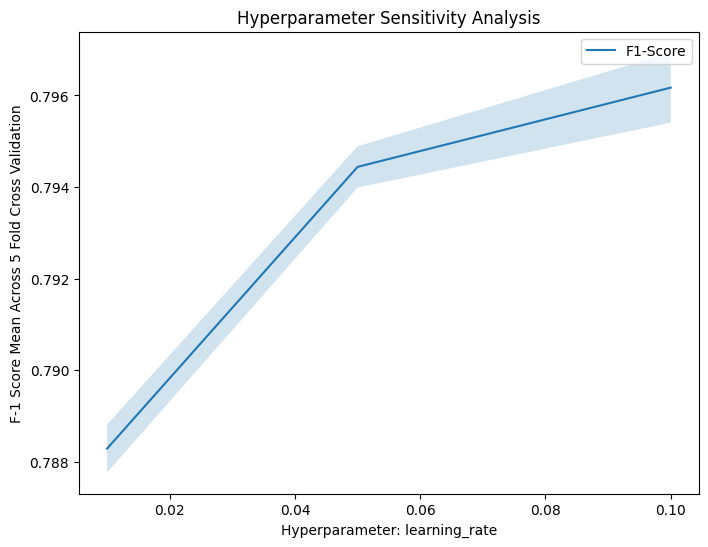

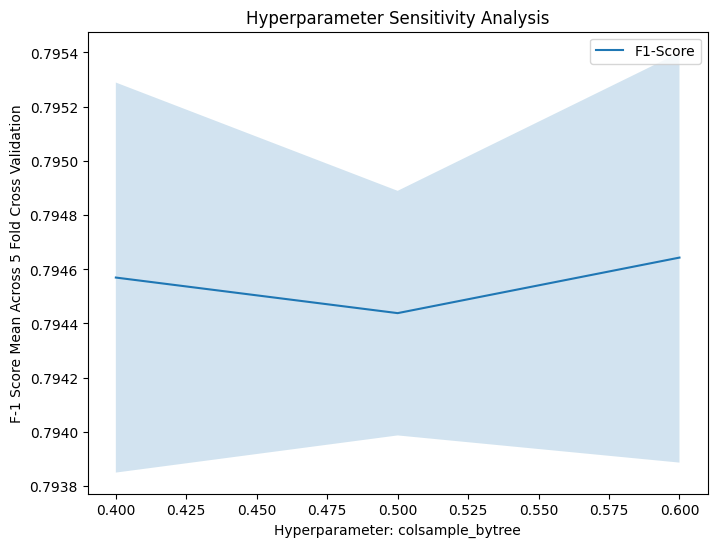

In [10]:

param_list = ['subsample', 'n_estimators', 'max_depth', 'learning_rate', 'colsample_bytree']

for param_filter in param_list:
    # Filter data for 'subsample' param
    param_data = sensitivity_df[sensitivity_df['param'] == param_filter]

    # Create separate DataFrames for F1-Score
    f1_data = param_data[param_data['metric'] == 'F1-Score']

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot F1-Score
    sns.lineplot(x='value', y='cv_mean', data=f1_data, label='F1-Score', ax=ax)
    ax.fill_between(f1_data['value'], f1_data['cv_mean'] - f1_data['cv_std'], f1_data['cv_mean'] + f1_data['cv_std'], alpha=0.2)

    # Set labels and title for F1-Score plot
    ax.set_xlabel(f'Hyperparameter: {param_filter}')
    ax.set_ylabel('F-1 Score Mean Across 5 Fold Cross Validation')
    ax.set_title('Hyperparameter Sensitivity Analysis')
    ax.legend()

    # Show the plot
    plt.show()